In [1]:
import os
import zlib
import numpy as np
import PIL.Image as Image
from IPython.display import display

import torch
import torch.nn as nn
from torchvision import transforms

from vector_quantize_pytorch import VectorQuantize

In [2]:
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t-0.5
    t = t.unsqueeze(0)
    return t
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [3]:
class VectorQuantizedAutoencoder(nn.Module):
    def __init__(self, **vq_kwargs):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.GELU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                VectorQuantize(dim=128, **vq_kwargs),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(128, 3, kernel_size=3, stride=1, padding=1),
            ]
        )
        return

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, VectorQuantize):
                x_shape = x.shape[:-1]
                x_flat = x.reshape(x.size(0), -1, x.size(1))
                x_flat, indices, commit_loss = layer(x_flat)
                x = x_flat.reshape(*x_shape, -1)
            else:
                x = layer(x)
        return x.clamp(-1, 1), indices, commit_loss

In [4]:
def lossy_analysis_transform(img):
    x = pil_to_pt(img)
    z,indices,commit_loss = net(x)
    indices = indices.to(torch.int8).detach().to("cpu").numpy()
    return z,indices
    
def lossless_entropy_encode(z,indices):
    original_shape = z.shape
    compressed_img = zlib.compress(indices.tobytes(), level=9)
    return compressed_img, original_shape

def compress(img):
    z,indices = lossy_analysis_transform(img)
    compressed_img, original_shape = lossless_entropy_encode(z,indices)
    return compressed_img, original_shape

In [5]:
def entropy_decoder(compressed_img,original_shape):
    decompressed = zlib.decompress(compressed_img)
    indices = np.frombuffer(decompressed, dtype=np.int8)
    return ẑ

In [6]:
net = VectorQuantizedAutoencoder(codebook_size=256)
checkpoint = torch.load("vqvae_vimeo_checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
img = Image.open("kodim05.png");
img.save("kodim05.jpg", "JPEG", quality=5)
jpeg = Image.open("kodim05.jpg");

In [8]:
compressed_img, original_shape = compress(img);
print("Bytes in compressed image:", len(compressed_img))
x̂,indices = lossy_analysis_transform(img)

Bytes in compressed image: 18318


original image


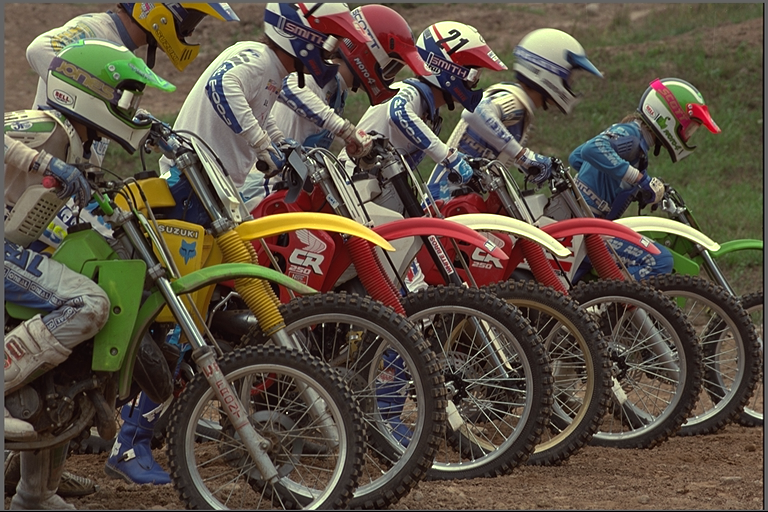

JPEG compression ratio 77.25771170345143


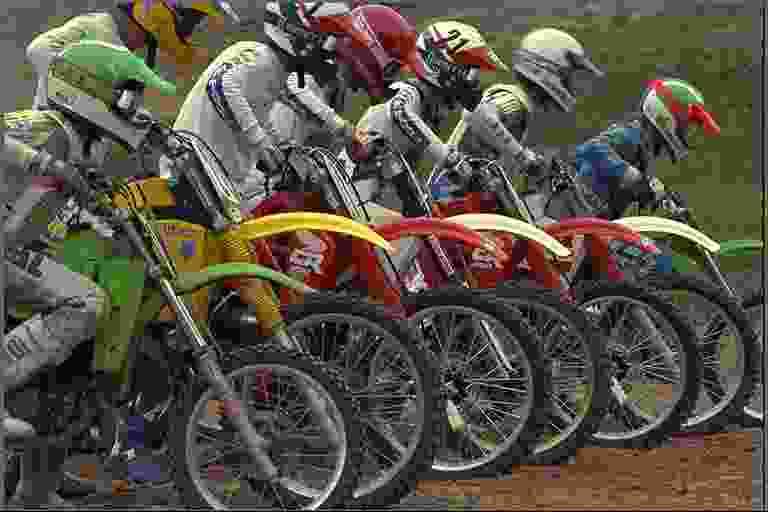

VQVAE compression ratio 64.39829675728791


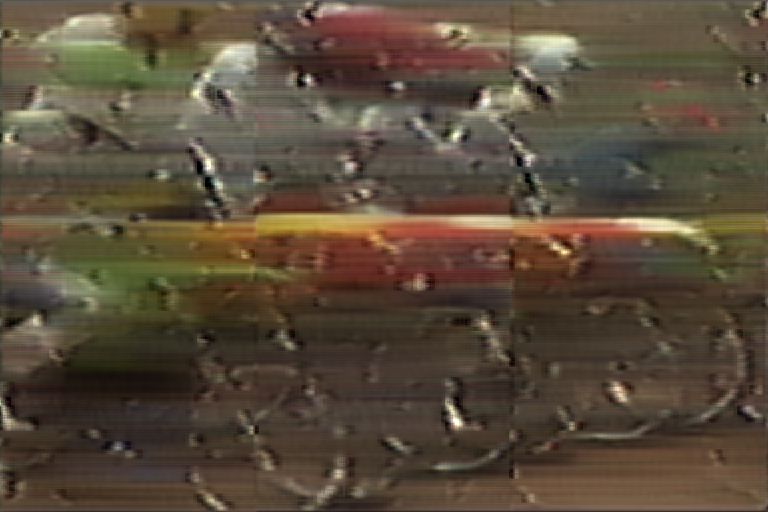

In [9]:
print('original image');
display(img)
print("JPEG compression ratio", (3*512*768)/os.path.getsize('kodim05.jpg'))
display(jpeg);
print("VQVAE compression ratio", (3*512*768)/len(compressed_img))
display(transforms.ToPILImage()(pt_to_pil(x̂)[0]))

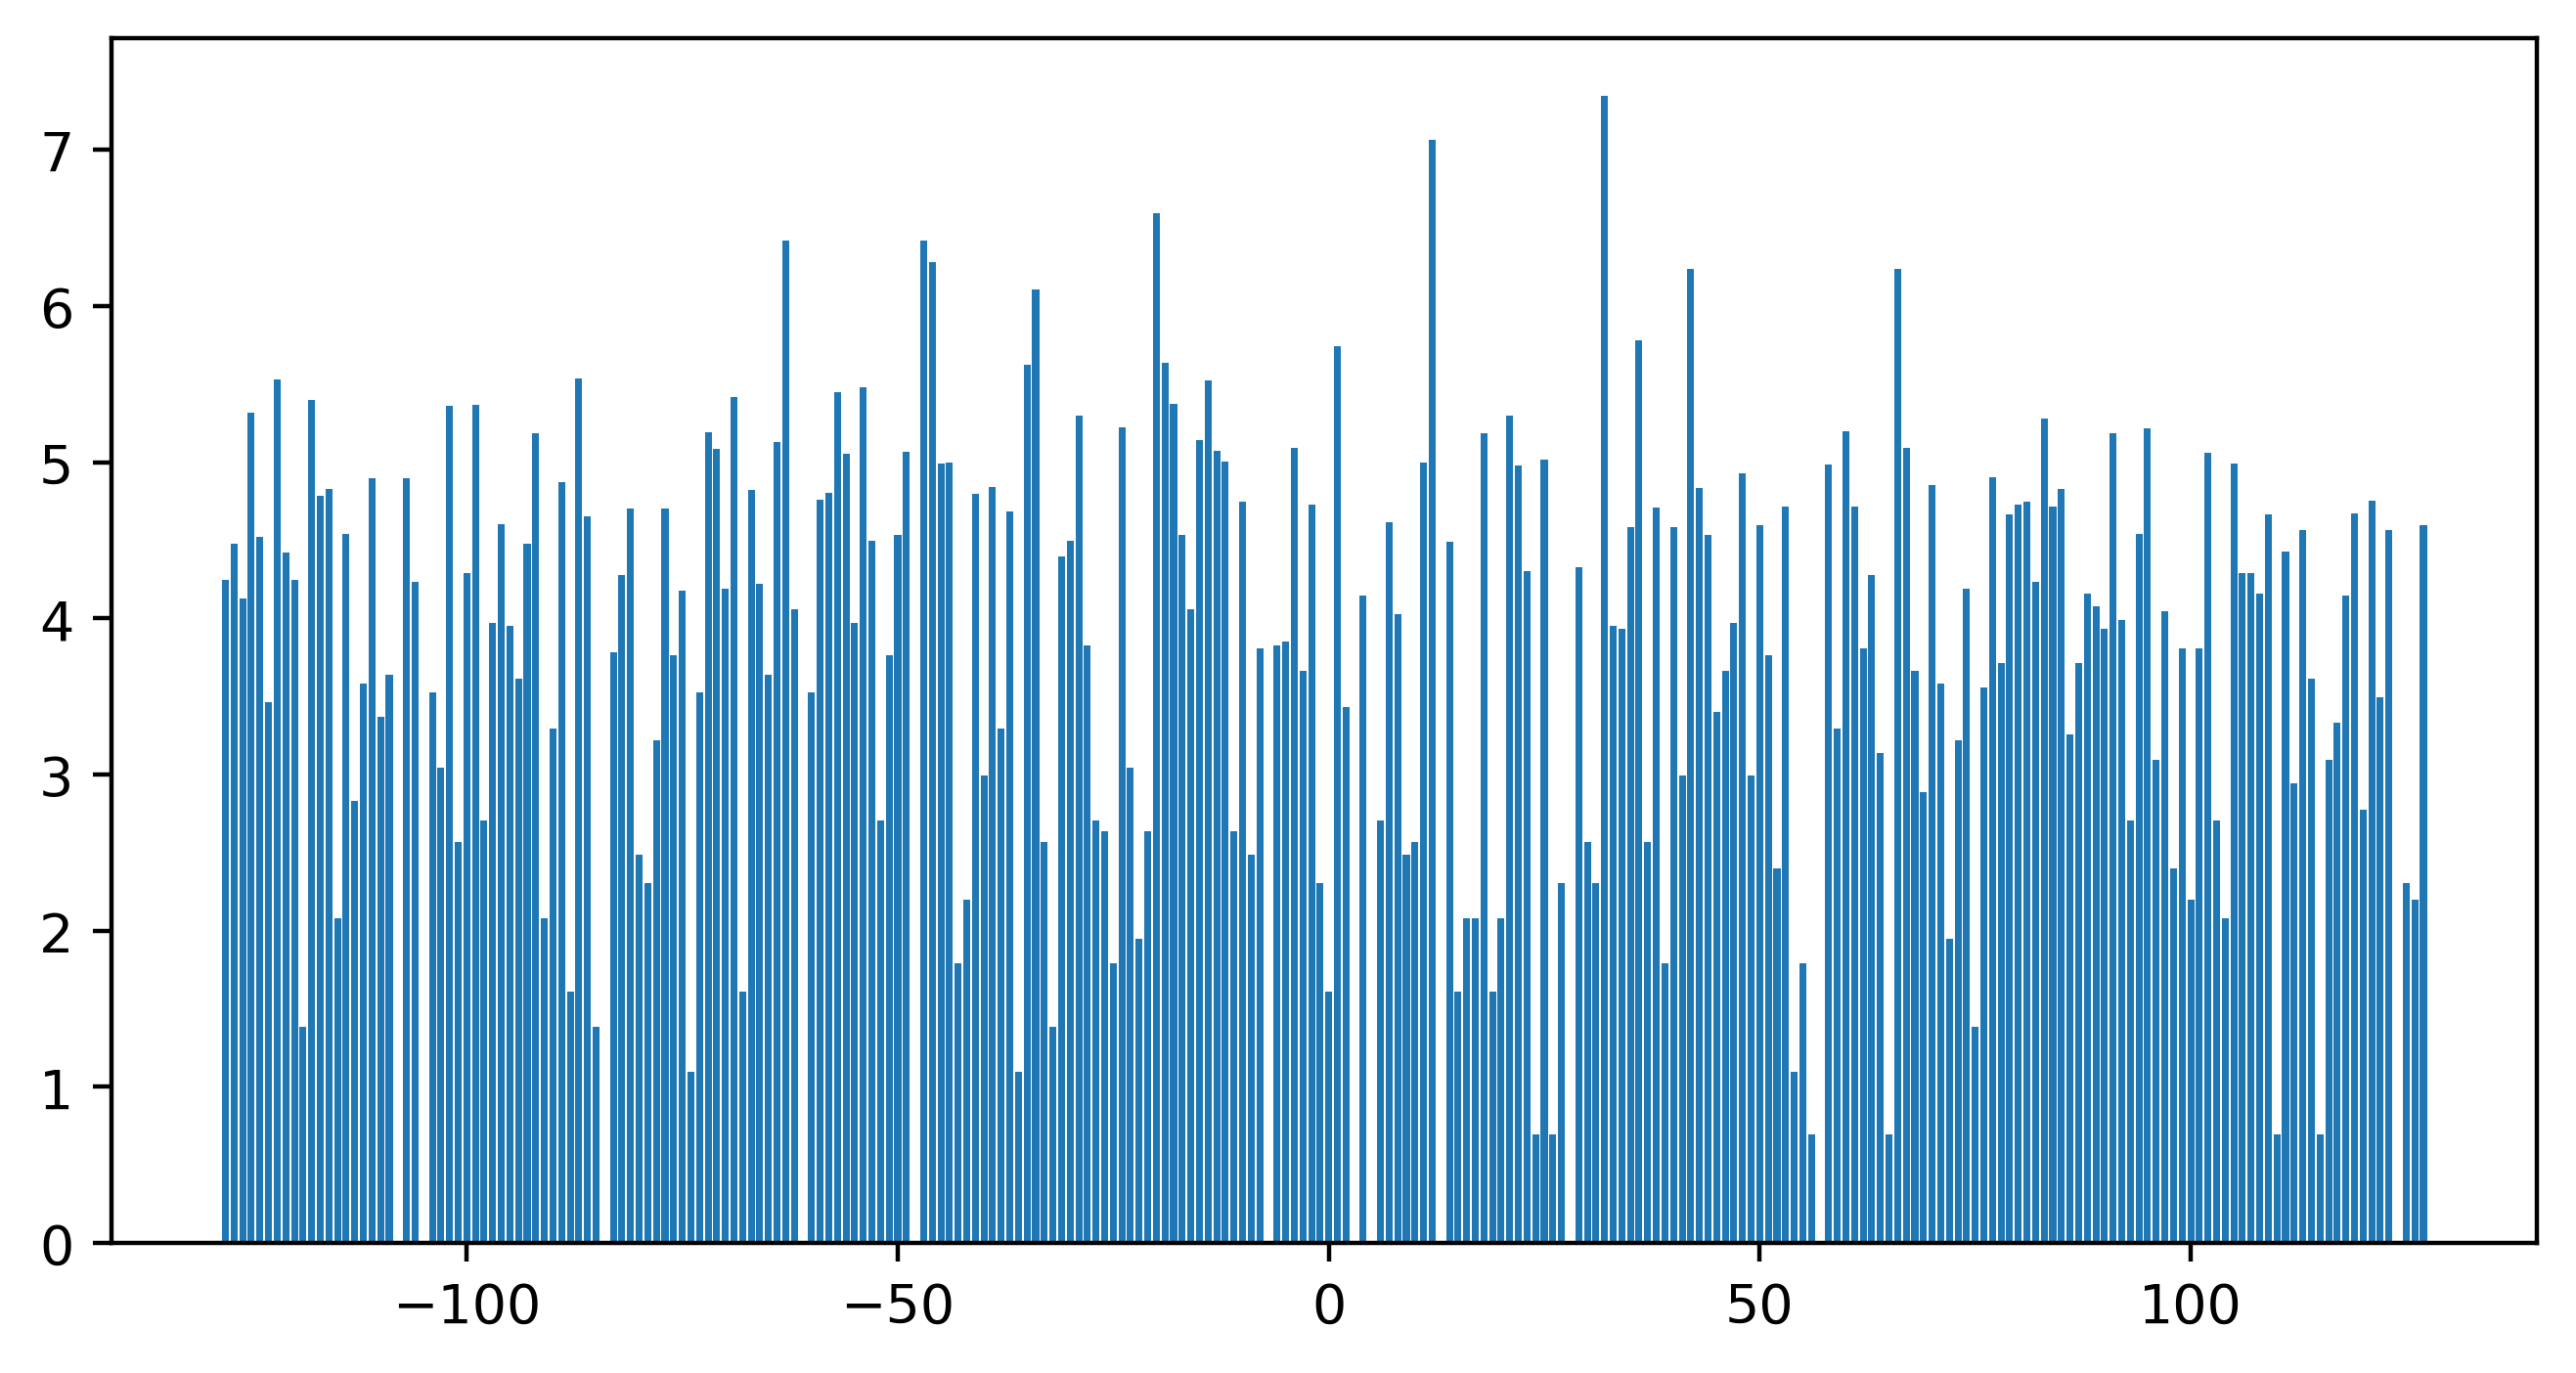

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4),dpi=400)
histogram = torch.histogram(torch.tensor(indices).to(torch.float),bins=256, range=(-128.5,127.5))
x = np.convolve(histogram.bin_edges,[0.5,0.5])[1:-1]
y = np.log(1+histogram.hist)
plt.bar(x,y);